In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Image_Augmentation.py
/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Original Dataset/Cancer/IMG (14).jpg
/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Original Dataset/Cancer/IMG (9).jpg
/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Original Dataset/Cancer/IMG (66).jpg
/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Original Dataset/Cancer/IMG (29).jpg
/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Original Dataset/Cancer/IMG (46).jpg
/kaggle/input/mamography

In [3]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from sklearn.model_selection import train_test_split
from datasets import load_metric
from sklearn.metrics import accuracy_score
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
!pip install -U accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 2.7 MB/s eta 0:00:00a 0:00:01m
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.32.1
    Uninstalling accelerate-0.32.1:
      Successfully uninstalled accelerate-0.32.1


**Set random seed for reproducibility**

In [4]:
import random
random.seed(10)

**Load dataset**

In [5]:
dataset = load_dataset(
    "imagefolder",
    data_dir="/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Original Dataset",
    split='train'
)

Resolving data files:   0%|          | 0/745 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

**Split dataset**

In [8]:
from collections import Counter
splits = dataset.train_test_split(test_size=0.2, seed=30, shuffle=True)
train_ds = splits['train']
val_ds = splits['test']

print(train_ds)
print(val_ds)

# Obtain the labels of each dataset
train_labels = [x['label'] for x in train_ds]
val_labels = [x['label'] for x in val_ds]

# Calculate the frequency of each label
train_counter = Counter(train_labels)
val_counter = Counter(val_labels)

Dataset({
    features: ['image', 'label'],
    num_rows: 596
})
Dataset({
    features: ['image', 'label'],
    num_rows: 149
})


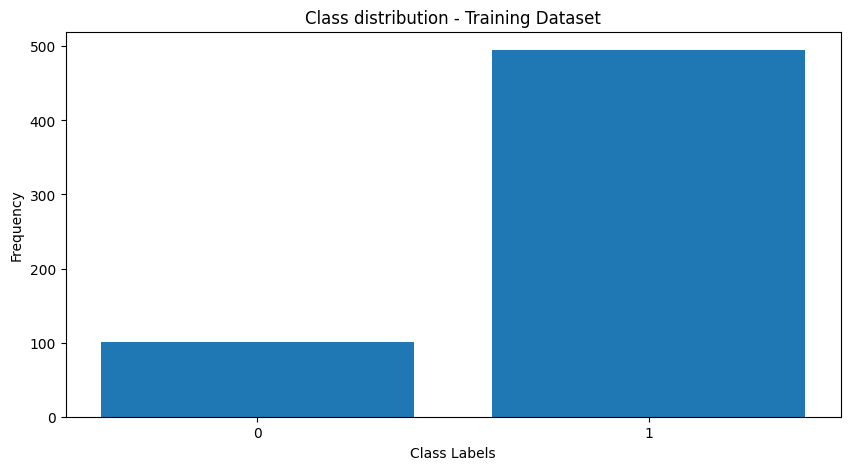

In [9]:
plt.figure(figsize=(10, 5))
plt.bar(train_counter.keys(), train_counter.values())
plt.title('Class distribution - Training Dataset')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.xticks(list(train_counter.keys()))
plt.show()

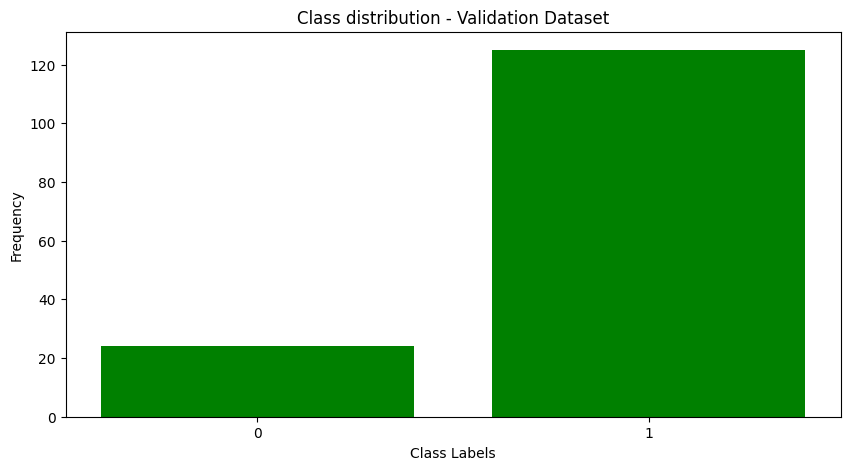

In [10]:
plt.figure(figsize=(10, 5))
plt.bar(val_counter.keys(), val_counter.values(), color='g')
plt.title('Class distribution - Validation Dataset')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.xticks(list(val_counter.keys()))
plt.show()

**Prepare label mapping**

In [11]:
labels = dataset.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
print(label2id)
print(id2label)

{'Cancer': 0, 'Non-Cancer': 1}
{0: 'Cancer', 1: 'Non-Cancer'}


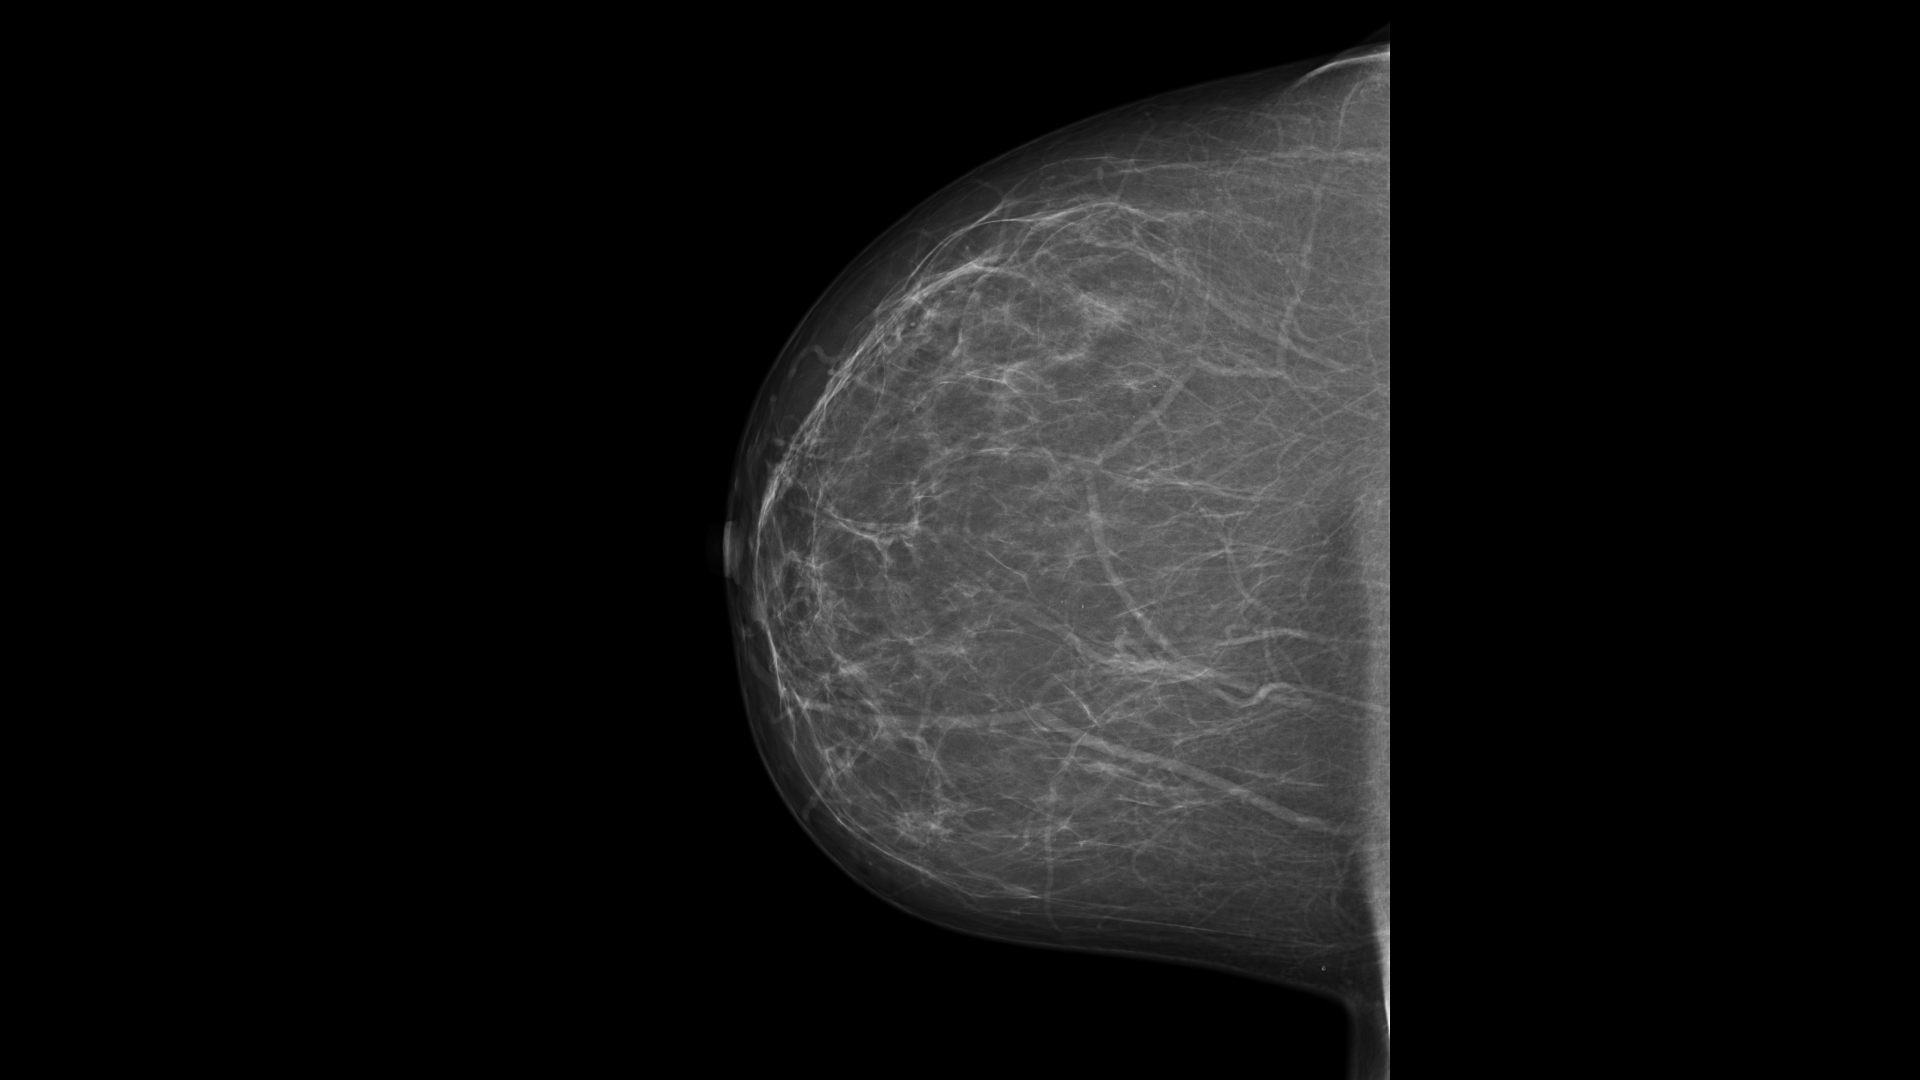

In [12]:
val_ds[0]['image']

In [13]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor
)
class DummyProcessor:
    def __init__(self):
        self.image_mean = [0.485, 0.456, 0.406]
        self.image_std = [0.229, 0.224, 0.225]
        self.size = {"height": 224, "width": 224}

processor = DummyProcessor()
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose([
    RandomResizedCrop(size),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])

_val_transforms = Compose([
    Resize(size),
    CenterCrop(size),
    ToTensor(),
    normalize,
])

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)

from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    id2label=id2label,
    label2id=label2id
)

def collate_fn(batch):
    pixel_values = torch.stack([x["pixel_values"] for x in batch])
    labels = torch.tensor([x["label"] for x in batch])
    return {"pixel_values": pixel_values, "labels": labels}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2024-08-21 13:06:18.761831: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 13:06:18.761933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 13:06:18.888458: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all in

Epoch,Training Loss,Validation Loss,Accuracy
1,0.520800,0.352173,0.838926
2,0.428300,0.276188,0.838926
3,0.303000,0.199861,0.885906
4,0.288600,0.156021,0.979866
5,0.266600,0.121834,0.979866
6,0.194500,0.109558,0.986577
7,0.252000,0.112579,0.979866
8,0.210600,0.088952,1.000000
9,0.205100,0.085984,1.000000
10,0.228000,0.086377,0.993289


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

Validation Loss: 0.0864
Validation Accuracy: 0.9933


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Testing Accuracy: 0.9933


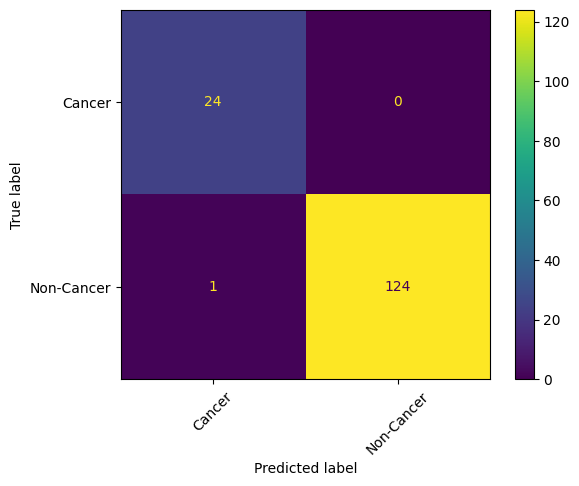

In [14]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    "breast_cancer_detection_v12",
    save_strategy="no",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=False,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    report_to='tensorboard',
    remove_unused_columns=False,
    logging_steps=10,  # Log metrics every 10 steps
)

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)
train_results = trainer.train()
eval_results = trainer.evaluate(val_ds)
print(f"Validation Loss: {eval_results['eval_loss']:.4f}")
print(f"Validation Accuracy: {eval_results['eval_accuracy']:.4f}")
test_results = trainer.predict(val_ds)
y_true = test_results.label_ids
y_pred = np.argmax(test_results.predictions, axis=1)
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Testing Accuracy: {test_accuracy:.4f}")
labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)
plt.show()

**preiction**

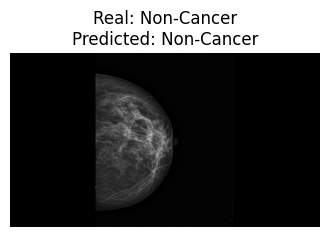

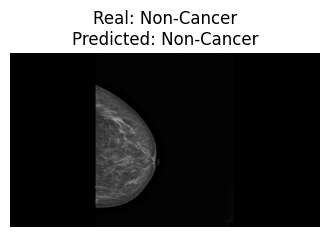

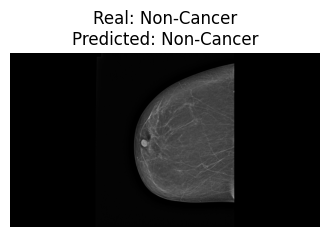

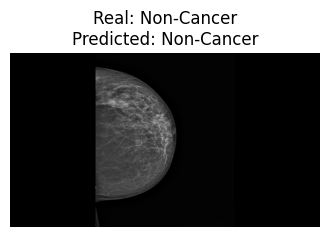

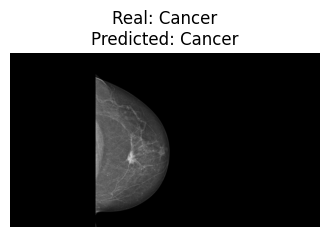

In [17]:
import random
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_samples = 5
samples = random.sample(list(val_ds), num_samples)
for sample in samples:
    image = sample['image']
    real_label = id2label[sample['label']]
    input_tensor = _val_transforms(image.convert("RGB")).unsqueeze(0)  # Add batch dimension
    input_tensor = input_tensor.to(device)  # Move input tensor to the same device as the model
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
    predicted_label_id = outputs.logits.argmax(-1).item()
    predicted_label = id2label[predicted_label_id]
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(f"Real: {real_label}\nPredicted: {predicted_label}")
    plt.axis("off")
    plt.show()

# Model Explanation with GradCAM

In [33]:
def plot_cam(model: models.resnet.ResNet, image_paths: list, targets: list) -> None:
    model = model.eval()
    
    target_layer = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layer)

    plt.rcParams['axes.grid'] = False
    fig, axs = plt.subplots(2, 4, figsize=(14, 7))

    for i, (image_path, target) in enumerate(zip(image_paths, targets)):
        image = Image.open(image_path).convert('RGB')
        image = transforms.ToTensor()(image)
        
        image_tensor = image.unsqueeze(0)
        
        image = image.numpy().transpose((1, 2, 0))
        image = np.clip(image, 0, 1)
        
        targets = [ClassifierOutputTarget(target)]
        grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        visualization = show_cam_on_image(np.array(image_tensor[0].permute(1, 2, 0)), grayscale_cam, use_rgb=True)

        axs[1, i].imshow(image)
        axs[1, i].set_title('Original')

        axs[0, i].imshow(visualization)
        axs[0, i].set_title('Grad-CAM')

    plt.tight_layout()
    plt.show()

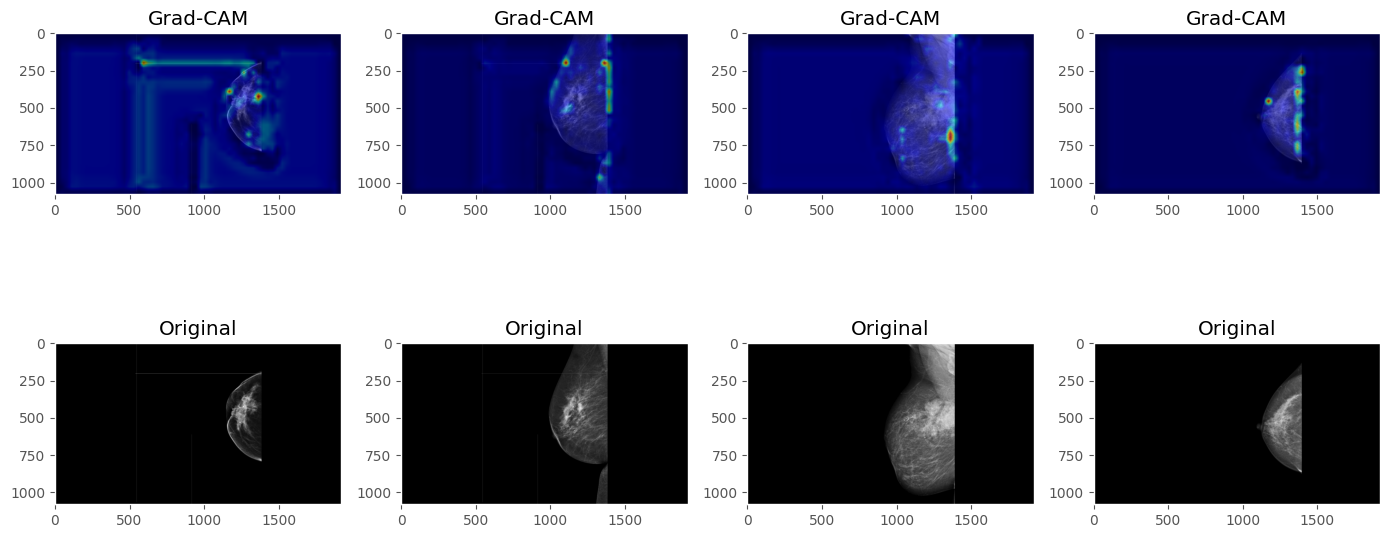

In [34]:
image_paths = [os.path.join(cancer_path, filename) for filename in os.listdir(cancer_path)][24:28]
plot_cam(best_model, image_paths, [1] * 4)

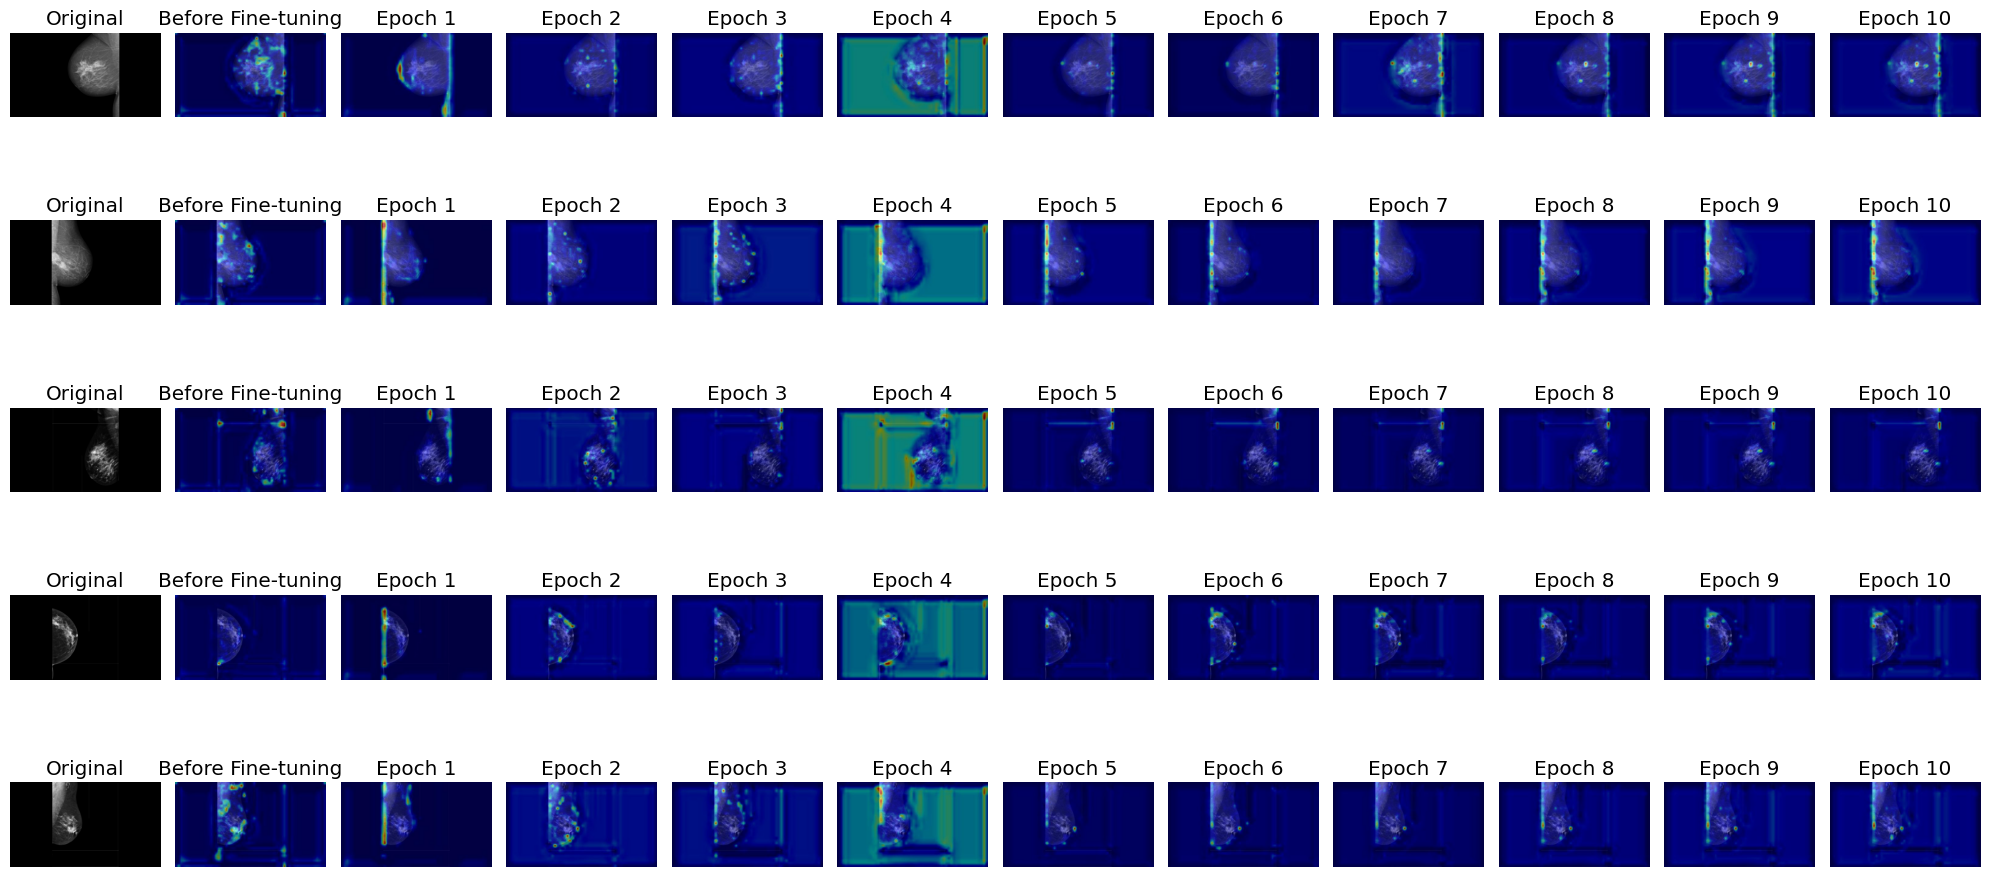

In [35]:
samples = [
    '/kaggle/working/samples/IMG (1).jpg',
    '/kaggle/working/samples/IMG (10).jpg',
    '/kaggle/working/samples/IMG (103).jpg',
    '/kaggle/working/samples/IMG (107).jpg',
    '/kaggle/working/samples/IMG (112).jpg'
]

fig, axs = plt.subplots(len(samples), max_epochs + 2, figsize=(20, 10))
start_index = 0
for row in range(len(samples)):
    filename = Image.open(samples[start_index])
    axs[row, 0].imshow(filename, cmap='gray')
    axs[row, 0].set_title('Original')
    axs[row, 0].axis('off')
    start_index += 1

    original_filename = filename.filename.split("/")[-1].split(".")[0]

    for col in range(1, max_epochs + 2):
        filename = Image.open(f'samples/{original_filename}-cam-epoch-{col-1}.jpg')
        axs[row, col].imshow(filename, cmap='gray')
        if col == 0:
            title = "Original"
        if col == 1:
            title = "Before Fine-tuning"
        if col > 1:
            title = f'Epoch {col - 1}'
        axs[row, col].set_title(title)
        axs[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
https://github.com/jacobgil/pytorch-grad-cam
    